In [2]:
import numpy as np
import pandas as pd
import glob
from scipy import ndimage
from scipy import ndimage
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
from collections import OrderedDict as odict
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib
from matplotlib import transforms
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size']=14
fs = 14

%matplotlib notebook

### Make the discovery image
Note that I use data from Apr 10, not the first detection epoch

In [3]:
ra, dec = np.loadtxt("../data/detection_pos/coo_kowalski.reg")

In [4]:
hw = 150

In [5]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
dA_Mpc = cosmo.angular_diameter_distance(z = 0.0213).value # in Mpc
dA_Mpc * 5 / (60*60) / 180 * np.pi * 1e+3 # in kpc

2.155616634998802

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
dA_Mpc = cosmo.angular_diameter_distance(z = 0.0213).value # in Mpc
dA_Mpc * 20 / (60*60) / 180 * np.pi * 1e+3 # in kpc

8.622466539995209

### Galaxy position:

In [7]:
# dA_Mpc * sep2g / (60*60) / 180 * np.pi * 1e+3 # in kpc 

In [8]:
from astropy.visualization import (MinMaxInterval, SqrtStretch, LinearStretch,
                                   ImageNormalize, LogStretch)

In [9]:
ra_hst, dec_hst = np.loadtxt("../data/detection_pos/coo_hst.reg")
dec_hst_ = dec_hst+0.001
ra_hst_ = ra_hst+0.001

In [10]:
hdu2 = fits.open("../data/hst/MAST_2020-03-01T1848/HST/idyq7b030/idyq7b030_drz.fits")[1]
wcs2 = WCS(hdu2.header)
x2, y2 = wcs2.wcs_world2pix(ra_hst, dec_hst, 0)
xint2 = int(x2)
yint2 = int(y2)
print (x2, y2)
hw = 50
hw_bod = 200
xpos = x2 - (xint2-hw)
ypos = y2 - (yint2-hw)
xpos_bod = x2 - (xint2-hw_bod)
ypos_bod = y2 - (yint2-hw_bod)

564.6921327863023 536.2070214165964


In [11]:
image2 = hdu2.data[yint2-hw:yint2+hw, xint2-hw:xint2+hw]
image2_bod = hdu2.data[yint2-hw_bod:yint2+hw_bod, xint2-hw_bod:xint2+hw_bod]

In [12]:
pixscale2 = fits.open("../data/hst/MAST_2020-03-01T1848/HST/idyq7b030/idyq7b030_drz.fits")[0].header["D001SCAL"] # Drizzle, pixel size (arcsec) of output image
print (pixscale2)

0.03962000086903572


In [13]:
norm1 = ImageNormalize(image2_bod, interval=MinMaxInterval(),stretch=LogStretch())
norm = ImageNormalize(image2, interval=MinMaxInterval(),stretch=LogStretch())

In [14]:
dA_Mpc * 0.5 / (60*60) / 180 * np.pi * 1e+3 # in kpc

0.2155616634998802

In [15]:
dA_Mpc * 2 / (60*60) / 180 * np.pi * 1e+3 # in kpc

0.8622466539995208

In [16]:
image2.shape

(100, 100)

In [17]:
2/pixscale2

50.479554672677025

<IPython.core.display.Javascript object>


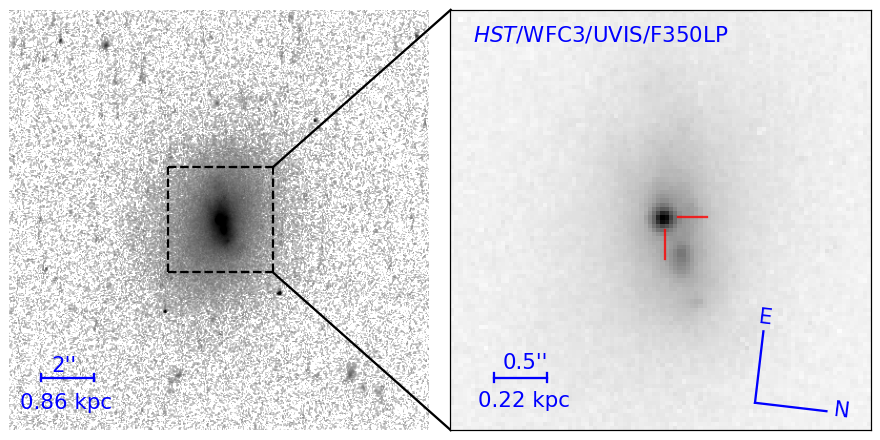

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


In [18]:
plt.figure(figsize = (8., 4.))
ax1 = plt.subplot(121)
ax1.imshow(image2_bod, origin = "lower", norm=norm1, vmin = 0, vmax = 2, cmap = "Greys")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot([xpos_bod-hw, xpos_bod-hw], [ypos_bod-hw, ypos_bod+hw], '--', linewidth = 1.5, alpha = 1, color = "k")
ax1.plot([xpos_bod+hw, xpos_bod+hw], [ypos_bod-hw, ypos_bod+hw], '--', linewidth = 1.5, alpha = 1, color = "k")
ax1.plot([xpos_bod-hw, xpos_bod+hw], [ypos_bod-hw, ypos_bod-hw], '--', linewidth = 1.5, alpha = 1, color = "k")
ax1.plot([xpos_bod-hw, xpos_bod+hw], [ypos_bod+hw, ypos_bod+hw], '--', linewidth = 1.5, alpha = 1, color = "k")
plt.axis('off')
ax1.set_xlim(0, 2*hw_bod)
ax1.set_ylim(0, 2*hw_bod)

ax1.plot([xpos_bod+hw, 2*hw_bod+20], [ypos_bod+hw, 2*hw_bod], '-', linewidth = 1.5, alpha = 1, color = "k", clip_on = False)
ax1.plot([xpos_bod+hw, 2*hw_bod+20], [ypos_bod-hw, 0], '-', linewidth = 1.5, alpha = 1, color = "k", clip_on = False)

xstart = 30
xend = xstart+2/pixscale2
yline = 50
ax1.plot([xstart, xend], [yline, yline], '-', color = 'b', linewidth = 1.5)
ax1.plot([xstart, xstart], [yline-3, yline+3], '-', color = 'b', linewidth = 1.5)
ax1.plot([xend, xend], [yline-3, yline+3], '-', color = 'b', linewidth = 1.5)
ax1.text(xstart+10, yline+5, "2''", color = 'b')
ax1.text(xstart-20, yline-30, "0.86 kpc", color = 'b')

ax = plt.subplot(122)
ax.imshow(image2, origin = "lower", norm=norm, cmap = "Greys")
ax.set_xticks([])
ax.set_yticks([])
ax.plot([xpos, xpos], [ypos-3, ypos-10], 'r-', linewidth = 1.5, alpha = 0.8)
ax.plot([xpos+3, xpos+10], [ypos, ypos], 'r-', linewidth = 1.5, alpha = 0.8)
xstart = 10
xend = xstart+0.5/pixscale2
yline = 12
ax.plot([xstart, xend], [yline, yline], '-', color = 'b', linewidth = 1.5)
ax.plot([xstart, xstart], [yline-1, yline+1], '-', color = 'b', linewidth = 1.5)
ax.plot([xend, xend], [yline-1, yline+1], '-', color = 'b', linewidth = 1.5)
ax.text(xstart+2, yline+2, "0.5''", color = 'b')
ax.text(xstart-4, yline-7, "0.22 kpc", color = 'b')
ax.text(5, hw*2-8, '$HST$/WFC3/UVIS/F350LP', color = 'b')
# North east
if 1+1==2:
    linecolor = "b"
    textcolor = "b"
    longlength = 17
    shortlength = 2
    tol = 1.5
    ax.plot([72, 72 + longlength], [6, 6-shortlength], '-', color = linecolor)
    ax.plot([72, 72 + shortlength], [6, 6+longlength], '-', color = linecolor)
    ax.text(72 + longlength+tol, 6-shortlength-tol, 'N', fontsize=fs, color = textcolor, rotation = -7)
    ax.text(72 + shortlength-tol, 6+longlength+tol, 'E', fontsize=fs, color = textcolor, rotation = -7)
    
plt.tight_layout(w_pad = -1.2, rect = [-0.03, -0.03, 1.03, 1.03])
plt.savefig("../paper/figures/offset.pdf")